In [2]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer

## 1. Read the data

In [3]:
# read the txt file
amazon = pd.read_table("amazon_cells_labelled.txt", quotechar="\t", header = None, names = ["Sentence", "Label"])
imdb = pd.read_table("imdb_labelled.txt", quotechar="\t", header = None, names = ["Sentence", "Label"])
yelp = pd.read_table("yelp_labelled.txt", quotechar="\t", header = None, names = ["Sentence", "Label"])

In [4]:
# merge the three table
original = pd.concat([amazon,imdb,yelp])
original = original.set_index(np.arange(0,3000))
original

,Sentence,Label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
2995,I think food should have flavor and texture an...,0
2996,Appetite instantly gone.,0
2997,Overall I was not impressed and would not go b...,0
2998,"The whole experience was underwhelming, and I ...",0


## 2. Clean the data - Filter out punctuation

In [5]:
# tokenize
words = []

for i in range(0, len(original)):
    sentence = original['Sentence'].iloc[i]
    tokens = sentence.translate(str.maketrans(string.punctuation,' '*len(string.punctuation))).split(' ')
    words = words + tokens

In [6]:
# clean the wordslist
vectorizer = CountVectorizer()
vectorizer.fit(words)

sentence_list = original['Sentence'].tolist()
vector = vectorizer.transform(sentence_list)

In [7]:
original['Count_Array'] = pd.Series(vector.toarray().tolist())
original

,Sentence,Label,Count_Array
0,So there is no way for me to plug it in here i...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Good case, Excellent value.",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Great for the jawbone.,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Tied to charger for conversations lasting more...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,The mic is great.,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
2995,I think food should have flavor and texture an...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2996,Appetite instantly gone.,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2997,Overall I was not impressed and would not go b...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2998,"The whole experience was underwhelming, and I ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 3. Feature Selection

### 3.1 Prune the word by selecting those whose count above medium

In [8]:
df = pd.DataFrame(index = np.arange(0,3000), columns = ['word','count'])

word_countArray = vector.toarray()
word_list = vectorizer.get_feature_names_out()

for i in range(0, len(word_list)):
    sum = 0
    for j in range(0, len(original)):
        sum += word_countArray[j][i]
    df.loc[i] = [word_list[i], sum]

In [9]:
# find medium
df_med = df.sort_values(by = 'count', ascending=False)
df_med = df_med.reset_index(drop=True)

if len(df)%2 == 0:
    medium1 = df_med['count'][len(df_med)/2]
    medium2 = df_med['count'][len(df_med)/2 + 1]
    medium = (medium1 + medium2)/2
else:
    medium = df_med['count'][(len(df_med) + 1)/2]

medium

1

### 3.2 Prune the word by selecting those whose count above average

In [10]:
# since the medium count is 1 which does not make sense if we prune by it, we prune by the average instead
avg = round(df['count'].sum()/len(df))
df_prune = df[df['count']>avg]

In [11]:
vectorizer_p = CountVectorizer()
vectorizer_p.fit(df_prune['word'])

sentence_list = original['Sentence'].tolist()
vector_prune = vectorizer_p.transform(sentence_list)

word_countArray_p = vector_prune.toarray()
word_countArray_p

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 4. Data Preprocessing for Model

### 4.1 Original Data

In [12]:
X = word_countArray
y = original['Label']

from sklearn.model_selection import train_test_split
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_remain, y_remain, test_size=0.5)

train_set = pd.DataFrame(columns=['Count_Array','Label'])
train_set['Count_Array'] = pd.Series(X_train.tolist())
train_set['Label'] = pd.Series(y_train.reset_index(drop=True))

test_set = pd.DataFrame(columns=['Count_Array','Label'])
test_set['Count_Array'] = pd.Series(X_test.tolist())
test_set['Label'] = pd.Series(y_test.reset_index(drop=True))

### 4.2 Pruned Data

In [13]:
# split the data
Xp = word_countArray_p
yp = original['Label']

Xp_train, Xp_remain, yp_train, yp_remain = train_test_split(Xp, yp, test_size=0.3)
Xp_test, Xp_valid, yp_test, yp_valid = train_test_split(Xp_remain, yp_remain, test_size=0.5)

train_set_p = pd.DataFrame(columns=['Count_Array','Label'])
train_set_p['Count_Array'] = pd.Series(Xp_train.tolist())
train_set_p['Label'] = pd.Series(yp_train.reset_index(drop=True))

test_set_p = pd.DataFrame(columns=['Count_Array','Label'])
test_set_p['Count_Array'] = pd.Series(Xp_test.tolist())
test_set_p['Label'] = pd.Series(yp_test.reset_index(drop=True))

## 5. Model Building

### 5.1 Implement of Naive Bayes Model

In [14]:
from sklearn.metrics import classification_report
import time

In [15]:
def word_count(word_list, df):
    wordCount = pd.DataFrame(columns = ['word','count'])

    for i in range(0, len(word_list)):
        sum = 0
        for j in range(0, len(df)):
            sum += df['Count_Array'].iloc[j][i]
        sum += 1
        wordCount.loc[i] = [word_list[i], sum]
    return wordCount

In [16]:
def probXYY(X_test, word_list, wordCount, Py):
    allCounts = wordCount['count'].sum()
    probility = []
    for i in range(0, len(X_test)):
        prod = 1
        for j in range(0, len(word_list)): 
            if X_test.iloc[i][j]!=0:
                currentWord_count = wordCount['count'][j]
                prod *= (currentWord_count/allCounts)
        probility.append(prod*Py)
    return(probility)

In [100]:
def predict(prob_posXYY, prob_negXYY):
    pred_result = []
    
    for i in range(0, len(prob_posXYY)):
        if prob_posXYY[i] >= prob_negXYY[i]:
            pred_result.append(1)
        else:
            pred_result.append(0)
    return pred_result

In [96]:
def classification(pred_result, test_set):
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    y_test = test_set['Label']
    
    for i in range(0, len(y_test)):
        if pred_result[i] == 1 and y_test.iloc[i] == 1:
            TP += 1
        elif pred_result[i] == 0 and y_test.iloc[i] == 0:
            TN += 1
        elif pred_result[i] == 1 and y_test.iloc[i] == 0:
            FP += 1
        else:
            FN += 1
    
    data = [[TP, FP],[FN, TN]]
    confusion_matrix = pd.DataFrame(data, index = ['Predictedly Positive','Predictedly Negative'], columns=['Actually Positive','Actually Negative'])
    return confusion_matrix

In [99]:
def NaiveBayes(word_list, train_set, test_set):
    
    # (1) Train the model
    # split the data into 2 categories: pos & neg
    pos = train_set[train_set['Label']==1].reset_index(drop=True)
    neg = train_set[train_set['Label']==0].reset_index(drop=True)
    
    wordCount_pos = word_count(word_list, pos)
    wordCount_neg = word_count(word_list, neg)
    
    # (2) Test the data
    
    # P(Y|X) = P(X|Y)*P(Y)/(P(X))
    # Since P(X) is the same no matter classification, we only need to calculate P(X|Y)*(P(Y)) for comparison by P(Y|X)
   
    # calculate the P(Y)
    p_pos = len(pos)/(len(train_set))
    p_neg = len(neg)/(len(train_set))
    
    # calculate the P(X|Y)*P(Y)
    X_test = test_set['Count_Array']
    prob_posXYY = probXYY(X_test, word_list, wordCount_pos, p_pos)
    prob_negXYY = probXYY(X_test, word_list, wordCount_neg, p_neg)
    
    # classification through comparision
    prediction = predict(prob_posXYY, prob_negXYY)
    return prediction

### 5.2 Original Data

#### 5.2.1.1 Naive Bayes - check the implement of Naive Bayes Model

In [103]:
prediction = NaiveBayes(word_list, train_set, test_set)
result = classification(prediction, test_set)
Accuracy = (result['Actually Positive'][0]+result['Actually Negative'][1])/len(test_set)
Accuracy

0.84

#### 5.2.1.2 Naive Bayes - for checking

In [32]:
import time

In [33]:
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()
nb = MultinomialNB()
nb.fit(X_train, y_train)
time_train_nb = (time.time() - start_time)

start_time = time.time()
predictions = nb.predict(X_test)
time_test_nb = (time.time() - start_time)

from sklearn.metrics import classification_report,confusion_matrix
confMatrix_nb = confusion_matrix(y_test,predictions)
accuracy_nb = (confMatrix_nb[0][0]+confMatrix_nb[1][1])/len(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("---Accuracy: %s ---" % accuracy_nb)
print("---training: %s seconds ---" % time_train_nb)
print("---testing: %s seconds ---" % time_test_nb)

[[188  32]
 [ 43 187]]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       220
           1       0.85      0.81      0.83       230

    accuracy                           0.83       450
   macro avg       0.83      0.83      0.83       450
weighted avg       0.83      0.83      0.83       450

---Accuracy: 0.8333333333333334 ---
---training: 0.28226518630981445 seconds ---
---testing: 0.04557085037231445 seconds ---



#### 5.2.2 Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
time_train_dt = (time.time() - start_time)

start_time = time.time()
predictions = dtree.predict(X_test)
time_test_dt = (time.time() - start_time)

confMatrix_dt = confusion_matrix(y_test,predictions)
accuracy_dt = (confMatrix_dt[0][0]+confMatrix_dt[1][1])/len(X_test)
print(classification_report(y_test, predictions))

print("---Accuracy: %s ---" % accuracy_dt)
print("---training: %s seconds ---" % time_train_dt)
print("---testing: %s seconds ---" % time_test_dt)

              precision    recall  f1-score   support

           0       0.74      0.80      0.76       220
           1       0.79      0.73      0.76       230

    accuracy                           0.76       450
   macro avg       0.76      0.76      0.76       450
weighted avg       0.76      0.76      0.76       450

---Accuracy: 0.76 ---
---training: 3.5158770084381104 seconds ---
---testing: 0.007216930389404297 seconds ---


#### 5.2.3 KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)

start_time = time.time()
knn.fit(X_train, y_train)
time_train_knn = (time.time() - start_time)

start_time = time.time()
predictions = knn.predict(X_test)
time_test_knn = (time.time() - start_time)

confMatrix_knn = confusion_matrix(y_test,predictions)
accuracy_knn = (confMatrix_knn[0][0]+confMatrix_knn[1][1])/len(X_test)
print(classification_report(y_test, predictions))

print("---Accuracy: %s ---" % accuracy_knn)
print("---training: %s seconds ---" % time_train_knn)
print("---testing: %s seconds ---" % time_test_knn)

              precision    recall  f1-score   support

           0       0.58      0.80      0.67       220
           1       0.70      0.45      0.55       230

    accuracy                           0.62       450
   macro avg       0.64      0.62      0.61       450
weighted avg       0.64      0.62      0.61       450

---Accuracy: 0.62 ---
---training: 0.007055997848510742 seconds ---
---testing: 0.31861400604248047 seconds ---


#### 5.2.4 SVM

In [36]:
from sklearn.svm import SVC
svm = SVC()

start_time = time.time()
svm.fit(X_train, y_train)
time_train_svm = (time.time() - start_time)

start_time = time.time()
predictions = svm.predict(X_test)
time_test_svm = (time.time() - start_time)

confMatrix_svm = confusion_matrix(y_test,predictions)
accuracy_svm = (confMatrix_svm[0][0]+confMatrix_svm[1][1])/len(X_test)

print(classification_report(y_test, predictions))
print("---Accuracy: %s ---" % accuracy_svm)
print("---training: %s seconds ---" % time_train_svm)
print("---testing: %s seconds ---" % time_test_svm)

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       220
           1       0.84      0.73      0.78       230

    accuracy                           0.79       450
   macro avg       0.80      0.79      0.79       450
weighted avg       0.80      0.79      0.79       450

---Accuracy: 0.7933333333333333 ---
---training: 11.59023904800415 seconds ---
---testing: 8.071463823318481 seconds ---


### 5.3 Pruned Data

#### 5.3.1 Naive Bayes - check the implement of Naive Bayes Model

In [106]:
prediction_p = NaiveBayes(word_list, train_set_p, test_set_p)
result_p = classification(prediction_p, test_set_p)
Accuracy_p = (result_p['Actually Positive'][0]+result_p['Actually Negative'][1])/len(test_set)
Accuracy_p

0.7955555555555556

#### 5.3.1.2 Naive Bayes - for checking

In [39]:
nb = MultinomialNB()

start_time = time.time()
nb.fit(Xp_train, yp_train)
time_trainp_nb = (time.time() - start_time)

start_time = time.time()
predictions = nb.predict(Xp_test)
time_testp_nb = (time.time() - start_time)


confMatrixp_nb = confusion_matrix(yp_test,predictions)
accuracyp_nb = (confMatrixp_nb[0][0]+confMatrixp_nb[1][1])/len(Xp_test)
print(classification_report(yp_test, predictions))

print("---Accuracy: %s ---" % accuracyp_nb)
print("---training: %s seconds ---" % time_trainp_nb)
print("---testing: %s seconds ---" % time_testp_nb)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       221
           1       0.80      0.81      0.81       229

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450

---Accuracy: 0.8 ---
---training: 0.2897200584411621 seconds ---
---testing: 0.03202509880065918 seconds ---


#### 5.3.2 Decision Tree

In [40]:
dtree = DecisionTreeClassifier()

start_time = time.time()
dtree.fit(Xp_train, yp_train)
time_trainp_dt = (time.time() - start_time)

start_time = time.time()
predictions = dtree.predict(Xp_test)
time_testp_dt = (time.time() - start_time)

confMatrixp_dt = confusion_matrix(yp_test,predictions)
accuracyp_dt = (confMatrixp_dt[0][0]+confMatrixp_dt[1][1])/len(Xp_test)
print(classification_report(yp_test, predictions))

print("---Accuracy: %s ---" % accuracy_dt)
print("---training: %s seconds ---" % time_trainp_dt)
print("---testing: %s seconds ---" % time_testp_dt)

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       221
           1       0.72      0.70      0.71       229

    accuracy                           0.71       450
   macro avg       0.71      0.71      0.71       450
weighted avg       0.71      0.71      0.71       450

---Accuracy: 0.76 ---
---training: 2.012212038040161 seconds ---
---testing: 0.007369041442871094 seconds ---


#### 5.3.3 KNN

In [41]:
knn = KNeighborsClassifier(n_neighbors=2)

start_time = time.time()
knn.fit(Xp_train, yp_train)
time_trainp_knn = (time.time() - start_time)

start_time = time.time()
predictions = svm.predict(Xp_test)
time_testp_knn = (time.time() - start_time)

confMatrixp_knn = confusion_matrix(yp_test,predictions)
accuracyp_knn = (confMatrixp_knn[0][0]+confMatrixp_knn[1][1])/len(Xp_test)
print(classification_report(yp_test, predictions))

print("---Accuracy: %s ---" % accuracyp_knn)
print("---training: %s seconds ---" % time_trainp_knn)
print("---testing: %s seconds ---" % time_testp_knn)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       221
           1       0.93      0.89      0.91       229

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450

---Accuracy: 0.9111111111111111 ---
---training: 0.009019136428833008 seconds ---
---testing: 7.659377813339233 seconds ---


#### 5.3.4 SVM

In [42]:
svm = SVC()

start_time = time.time()
svm.fit(Xp_train, yp_train)
time_trainp_svm = (time.time() - start_time)

start_time = time.time()
predictions = svm.predict(Xp_test)
time_testp_svm = (time.time() - start_time)

confMatrixp_svm = confusion_matrix(yp_test,predictions)
accuracyp_svm = (confMatrixp_svm[0][0]+confMatrixp_svm[1][1])/len(Xp_test)
print(classification_report(yp_test, predictions))

print("---Accuracy: %s ---" % accuracyp_svm)
print("---training: %s seconds ---" % time_trainp_svm)
print("---testing: %s seconds ---" % time_testp_svm)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       221
           1       0.77      0.76      0.77       229

    accuracy                           0.77       450
   macro avg       0.77      0.77      0.77       450
weighted avg       0.77      0.77      0.77       450

---Accuracy: 0.7666666666666667 ---
---training: 11.247905969619751 seconds ---
---testing: 7.760913848876953 seconds ---


## 6. Comparision

### 6.1 Compare Accuracy

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

(0.0, 1.0)

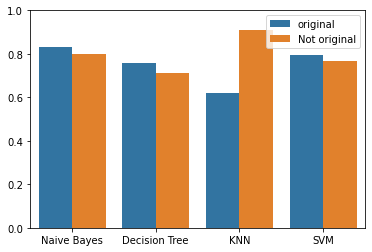

In [56]:
# Compare Accuracy under different models
models = ['Naive Bayes','Decision Tree','KNN','SVM','Naive Bayes','Decision Tree','KNN','SVM']
accuracy = [accuracy_nb, accuracy_dt, accuracy_knn, accuracy_svm, accuracyp_nb, accuracyp_dt, accuracyp_knn, accuracyp_svm]
dataset=['original','original','original','original','Not original','Not original','Not original','Not original']
sns.barplot(x = models, y = accuracy, hue = dataset)
plt.ylim(0, 1)

### 6.2 Compare Efficiency Cost

<AxesSubplot:>

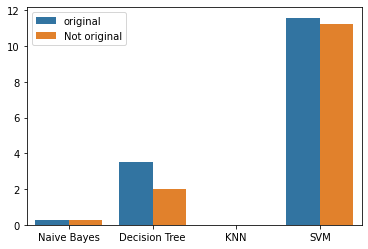

In [57]:
# Compare offline efficiency cost 
models = ['Naive Bayes','Decision Tree','KNN','SVM','Naive Bayes','Decision Tree','KNN','SVM']
efficiency_cost_offline = [time_train_nb,time_train_dt, time_train_knn, time_train_svm, time_trainp_nb,time_trainp_dt, time_trainp_knn, time_trainp_svm]
dataset=['original','original','original','original','Not original','Not original','Not original','Not original']
sns.barplot(x = models, y = efficiency_cost_offline, hue = dataset)

<AxesSubplot:>

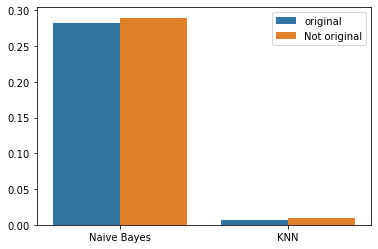

In [58]:
models = ['Naive Bayes', 'Naive Bayes', 'KNN','KNN']
efficiency_cost_offline = [time_train_nb, time_trainp_nb, time_train_knn, time_trainp_knn]
dataset=['original','Not original','original','Not original']
sns.barplot(x = models, y = efficiency_cost_offline, hue = dataset)

<AxesSubplot:>

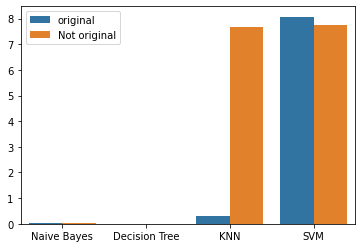

In [59]:
# Compare online efficiency cost 
models = ['Naive Bayes','Decision Tree','KNN','SVM','Naive Bayes','Decision Tree','KNN','SVM']
efficiency_cost_online = [time_test_nb,time_test_dt, time_test_knn, time_test_svm, time_testp_nb,time_testp_dt, time_testp_knn, time_testp_svm]
dataset=['original','original','original','original','Not original','Not original','Not original','Not original']
sns.barplot(x = models, y = efficiency_cost_online, hue = dataset)

<AxesSubplot:>

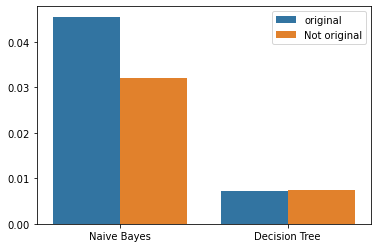

In [60]:
models = ['Naive Bayes','Decision Tree','Naive Bayes','Decision Tree']
efficiency_cost_online = [time_test_nb, time_test_dt, time_testp_nb,time_testp_dt]
dataset=['original','original','Not original','Not original']
sns.barplot(x = models, y = efficiency_cost_online, hue = dataset)

<AxesSubplot:>

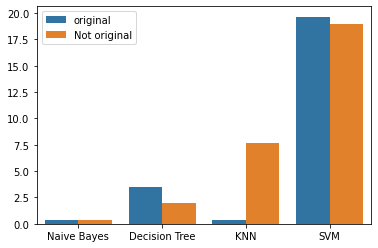

In [61]:
# Compare overall efficiency cost 
models = ['Naive Bayes','Decision Tree','KNN','SVM','Naive Bayes','Decision Tree','KNN','SVM']
time_nb = time_train_nb + time_test_nb
time_dt = time_train_dt + time_test_dt
time_knn = time_train_knn + time_test_knn
time_svm = time_train_svm + time_test_svm
timep_nb = time_trainp_nb + time_testp_nb
timep_dt = time_trainp_dt + time_testp_dt
timep_knn = time_trainp_knn + time_testp_knn
timep_svm = time_trainp_svm + time_testp_svm
efficiency_cost = [time_nb,time_dt, time_knn, time_svm, timep_nb,timep_dt, timep_knn, timep_svm]
dataset=['original','original','original','original','Not original','Not original','Not original','Not original']
sns.barplot(x = models, y = efficiency_cost, hue = dataset)

<AxesSubplot:>

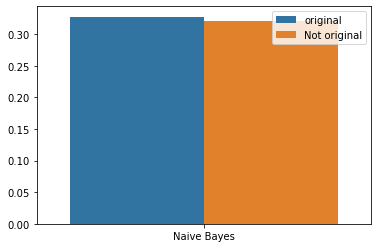

In [107]:
models = ['Naive Bayes', 'Naive Bayes']
efficiency_cost_offline = [time_nb,timep_nb]
dataset=['original','Not original']
sns.barplot(x = models, y = efficiency_cost_offline, hue = dataset)

## 6.3 Results

# 7. Examples

In [120]:
example_test = X_test[0:10]
example_actualValue = y_test[0:10]

# 10 sentences as example
X_value = original['Count_Array']
example_sentence = []
for i in range(0, len(original)):
    for j in range(0, 10):
        if (X_value.iloc[i] == X_test[j]).sum() == len(X_test[0]):
            example_sentence.append(original['Sentence'].iloc[i])
example_sentence

['Lately they have been extremely nice and helpful on the phone.',
 'Love This Phone.',
 'Excellent product for the price.',
 'I love this phone!.',
 'Excellent product for the price.',
 'This is actually a very smart movie.  ',
 'For people who are first timers in film making, I think they did an excellent job!!  ',
 "Being a 90's child, I truly enjoyed this show and I can proudly say that I enjoyed it big time and even more than the classical WB cartoons.  ",
 'There is, however, some pretty good acting (at least, for this type of film).  ',
 'But it picked up speed and got right to the point.  ',
 'I love this place.',
 'I love this place.',
 "It's NOT hard to make a decent hamburger."]

In [126]:
example_test_set = pd.DataFrame(columns=['Count_Array','Label'])
example_test_set['Count_Array'] = pd.Series(example_test.tolist())
example_test_set['Label'] = pd.Series(example_actualValue.reset_index(drop=True))

In [128]:
# Naive Bayes
predictions_nb = NaiveBayes(word_list, train_set, example_test_set)

print('Original Data')
print('Prediction: ', predictions_nb)
print('Actual: ', example_actualValue.to_numpy())

predictions_nbp = NaiveBayes(word_list, train_set_p, example_test_set)
print('Original Data')
print('Prediction: ', predictions_nbp)
print('Actual: ', example_actualValue.to_numpy())

Original Data
Prediction:  [1, 0, 1, 1, 1, 1, 1, 0, 1, 0]
Actual:  [1 1 1 1 1 1 1 0 1 1]
Original Data
Prediction:  [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]


In [89]:
# Decision Tree

dtree.fit(X_train, y_train)
predictions_dt = dtree.predict(example_test)

print('Original Data')
print('Prediction: ', predictions_dt)
print('Actual: ', example_actualValue.to_numpy())

dtree.fit(Xp_train, yp_train)
predictions_dtp = dtree.predict(example_test)
print('------------------------------------')
print('Pruned Data')
print('Prediction: ', predictions_dtp)
print('Actual: ', example_actualValue.to_numpy())

Original Data
Prediction:  [1 0 1 1 1 1 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]
------------------------------------
Pruned Data
Prediction:  [1 1 1 1 1 1 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]


In [95]:
# KNN

knn.fit(X_train, y_train)
predictions_knn = svm.predict(example_test)

print('Original Data')
print('Prediction: ', predictions_knn)
print('Actual: ', example_actualValue.to_numpy())

knn.fit(Xp_train, yp_train)
predictions_knnp = knn.predict(example_test)
print('------------------------------------')
print('Pruned Data')
print('Prediction: ', predictions_knnp)
print('Actual: ', example_actualValue.to_numpy())

Original Data
Prediction:  [1 1 1 1 1 1 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]
------------------------------------
Pruned Data
Prediction:  [0 0 1 1 1 0 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]


In [94]:
# SVM

svm.fit(Xp_train, yp_train)
predictions_svm = svm.predict(example_test)

print('Original Data')
print('Prediction: ', predictions_svm)
print('Actual: ', example_actualValue.to_numpy())

svm.fit(Xp_train, yp_train)
predictions_svmp = svm.predict(example_test)
print('------------------------------------')
print('Pruned Data')
print('Prediction: ', predictions_svmp)
print('Actual: ', example_actualValue.to_numpy())

Original Data
Prediction:  [1 1 1 1 1 1 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]
------------------------------------
Pruned Data
Prediction:  [1 1 1 1 1 1 1 0 1 1]
Actual:  [1 1 1 1 1 1 1 0 1 1]
